In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import erf

%matplotlib inline
#%matplotlib tk

In [2]:
def parameter_set (alpha1, beta1sr, capLam1, rho1, sigma10, alpha2, beta2sr, capLam2, rho2, sigma20, lam, norMu, norStd, meanCo, rhoJ, lamPri, meanId):
    parameters = {
        "alpha1" : alpha1,
        "beta1sr" : beta1sr,
        "capLam1" : capLam1,
        "rho1" : rho1,
        "sigma10" : sigma10,

        "alpha2" : alpha2,
        "beta2sr" : beta2sr,
        "capLam2" : capLam2,
        "rho2" : rho2,
        "sigma20" : sigma20,
        
        
        "lam" : lam,
        "norMu" : norMu,
        "norStd" : norStd,
        
        "meanCo" : meanCo,
        "rhoJ" : rhoJ,
        
        "lamPri" : lamPri,
        "meanId" : meanId}
    
    return parameters

In [3]:
para = parameter_set(1.676, 0.18219, .504, -.964, .16376, 6.488, .21531, 2.115, -1, .07984, .064, -.280, .413, .065, -.52, .013, .052)
para

{'alpha1': 1.676,
 'beta1sr': 0.18219,
 'capLam1': 0.504,
 'rho1': -0.964,
 'sigma10': 0.16376,
 'alpha2': 6.488,
 'beta2sr': 0.21531,
 'capLam2': 2.115,
 'rho2': -1,
 'sigma20': 0.07984,
 'lam': 0.064,
 'norMu': -0.28,
 'norStd': 0.413,
 'meanCo': 0.065,
 'rhoJ': -0.52,
 'lamPri': 0.013,
 'meanId': 0.052}

In [4]:
alpha1 = 1.676
beta1sr = 0.18219 
capLam1 = .504
rho1 = -.964
sigma10 = .16376

alpha2 = 6.488
beta2sr = .21531
capLam2 = 2.115
rho2 =  -1
sigma20 = .07984


lam =  .064
norMu = -.280
norStd = .413

meanCo =  .065
rhoJ =  -3.304

lamPri = .013
meanId = .052

alpha = np.array([[np.nan, alpha1, alpha2]]).T
betaSr = np.array([[np.nan, beta1sr, beta2sr]]).T
capLam = np.array([[np.nan, capLam1, capLam2]]).T
rho = np.array([[np.nan, rho1, rho2]]).T
sigma0 = np.array([[np.nan, sigma10, sigma20]]).T


In [5]:
def xi(z):
    
    xi = alpha - rho * capLam @ (1j *z)
    return xi

In [6]:
def dk(z):
    dk = np.sqrt(xi(z) ** 2 + z * (1j + z) * capLam ** 2)
    return dk

In [7]:
def GcoPlus(z):
    GcoPlus = 1 - 1j * z * rhoJ * meanCo - (meanCo / (capLam[1] ** 2)) * (xi(z)[1] + dk(z)[1])
    return GcoPlus

def GcoMinus(z):
    GcoMinus = 1 - 1j * z * rhoJ * meanCo - (meanCo / (capLam[1] ** 2)) * (xi(z)[1] - dk(z)[1])
    return GcoMinus


In [8]:
def GidPlus(z):
    GidPlus = 1 - (meanId / (capLam[1] ** 2)) * (xi(z)[1] + dk(z)[1])
    return GidPlus

def GidMinus(z):
    GidMinus = 1 - (meanId / (capLam[1] ** 2)) * (xi(z)[1] - dk(z)[1])
    return GidMinus


In [9]:
def gk(z):
    gk = (xi(z) - dk(z)) / (xi(z) + dk(z))
    return gk

In [10]:
def AkLogPrice(z, tau ):
    Ak = (alpha*betaSr**2/(capLam**2))*((xi(z)-dk(z))*tau-2*np.log((1-gk(z)*np.exp(-dk(z)*tau))/(1-gk(z))))
    return Ak

In [11]:
def BkLogPrice(z, tau):
    Bk = ((xi(z) - dk(z))*(1 - np.exp(-dk(z)*tau))) / (capLam**2*(1-gk(z)*np.exp(-dk(z)*tau)))
    return Bk

In [12]:
def ThetaCo(z, tau):
    theta1 = np.exp(1j*norMu*z - .5*norStd**2*z**2)
    logBlob = np.log((GcoMinus(z)-gk(z)[1]*GcoPlus(z)*np.exp(-dk(z)[1]*tau))/((1-gk(z)[1])*(1-1j*z*rhoJ*meanCo)))
    theta2 = (1/GcoMinus(z))*(1-(2*meanCo*logBlob)/(tau*capLam[1]**2*GcoPlus(z)))
    thetaCo = theta1 * theta2
    return thetaCo

def capCcoPrice(z, tau):
    muBar = np.exp(norMu+.5*norStd**2)/(1-meanCo*rhoJ) - 1
    capC = lam*tau*(ThetaCo(z, tau)-1-1j*muBar*z)
    return capC

In [13]:
def ThetaId(z, tau):
    logBlob = np.log((GidMinus(z)-gk(z)[1]*GidPlus(z)*np.exp(-dk(z)[1]*tau))/(1-gk(z)[1]))
    thetaId = (1/GidMinus(z))*(1-(2*meanId*logBlob)/(tau*capLam[1]**2*GidPlus(z)))
    return thetaId

def capCidPrice(z, tau):
    capC = lamPri*tau*(ThetaId(z, tau)-1)
    return capC

In [14]:
def AkSV(z, tau):
    Ak = -2*(alpha*betaSr**2/(capLam**2))*np.log(1-(capLam**2/(2*alpha)*(1-np.exp(-alpha*tau)))@(1j*z))
    return Ak

In [15]:
def BkSV(z, tau):
    Bk = (np.exp(-alpha*tau)@(1j*z))/(1-(capLam**2/(2*alpha)*(1-np.exp(-alpha*tau)))@(1j*z))
    return Bk

In [16]:
def Theta(z, mu, tau):
    logBlob = np.log(1-(1j*z*(capLam[1]**2-2*alpha[1]*mu)*(1-np.exp(-alpha[1]*tau)))/(2*alpha[1]*(1-1j*z*mu)))
    theta = -2*mu/(capLam[1]**2-2*alpha[1]*mu) * logBlob
    return theta

def capCcoSV(z, tau):
    capC = lam*Theta(z, meanCo, tau)
    return capC

def capCidSV(z, tau):
    capC = lamPri*Theta(z, meanId, tau)
    return capC

In [17]:
tauBar = 30/365
def aK(tauBar):
    ak = (1-np.exp(-tauBar*alpha))/alpha
    return ak

def b1(tauBar):
    muBar = np.exp(norMu+.5*norStd**2)/(1-meanCo*rhoJ) - 1

    first = (alpha[1]*betaSr[1]**2+lam*meanCo+lamPri*meanId)/alpha[1] * (tauBar-aK(tauBar)[1])
    second = 2*lam*tauBar*(muBar-(norMu+rhoJ*meanCo))
    b1 = first + second
    return b1

def b2(tauBar):
    b2 = betaSr[2]**2*(tauBar-aK(tauBar)[2])
    return b2

In [18]:
# Assuming x_t is x_0 = logS_0
S0=40 #Arbitrary choice
x0 = np.log(S0)
r = 0.0
q = 0.0

def CFlogPrice(z, tau):
    first = 1j*(x0+(r-q)*tau)*z
    second = AkLogPrice(z, tau)+BkLogPrice(z, tau)*sigma0**2
    secondSum = second[1] + second[2]
    CF = np.exp(first + secondSum + capCcoPrice(z, tau) + capCidPrice(z, tau))
    return CF

def CFSV(z1, z2, tau):
    sum1 = AkSV(z1, tau)[1] + BkSV(z1, tau)[1]*sigma0[1]**2
    sum2 = AkSV(z2, tau)[2] + BkSV(z2, tau)[2]*sigma0[2]**2
    CF = np.exp(sum1+sum2+capCcoSV(z1, tau)+capCidSV(z1, tau))
    return CF

In [19]:
def VIXopCall(z, tau, I, K):
    Z1 = -z * aK(tauBar)[1] / tauBar
    Z2 = -z * aK(tauBar)[2] / tauBar

    firstPart = CFSV(Z1, Z2, tau)
    secondPart = np.exp(-1j*z*(b1(tauBar)+b2(tauBar)+I)/tauBar) / ((-1j*z)**1.5)
    thirdPart = 1 - erf((K/100)*(-1j*z)**0.5)
    VIXopInteg = (firstPart*secondPart*thirdPart).real
    
    return VIXopInteg

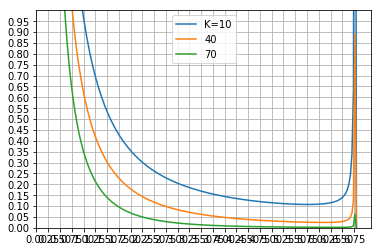

In [20]:
z = np.linspace(0.5, 6.8, 200) * 1j
z = np.array([z])
VIXcall4 = VIXopCall(z, 45/365, 0.0, 10).flatten()
VIXcall2 = VIXopCall(z, 45/365, 0.0, 40).flatten()
VIXcall3 = VIXopCall(z, 45/365, 0.0, 70).flatten()

imZ = z.imag.flatten()

#%matplotlib tk
plt.plot(imZ, VIXcall4)
plt.plot(imZ, VIXcall2)
plt.plot(imZ, VIXcall3)
plt.yticks(np.arange(0, 1, step=0.05))
plt.xticks(np.arange(0, 6.8, step=0.25))

plt.legend(['K=10', '40', '70'])
plt.ylim(0, 1.0)
plt.grid()

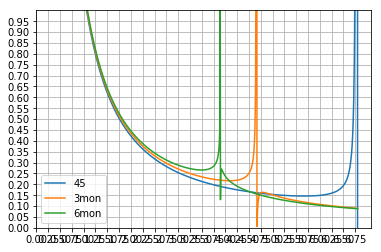

In [21]:
#tauBar=30
z = np.linspace(1, 6.8, 1000) * 1j
z = np.array([z])
def VIXfuPricing(z, tau, I):
    Z1 = -z * aK(tauBar)[1] / tauBar
    Z2 = -z * aK(tauBar)[2] / tauBar
    firstPart = CFSV(Z1, Z2, tau)
    secondPart = np.exp(-1j*z*(b1(tauBar)+b2(tauBar)+I)/tauBar) / ((-1j*z)**1.5)

    VIXfuInteg = (firstPart*secondPart).real
    return VIXfuInteg


VIXfu4 = VIXfuPricing(z, 45.0/365, 0.0).flatten()
VIXfu2 = VIXfuPricing(z, .25, 0.0).flatten()
VIXfu3 = VIXfuPricing(z, .5, 0.0).flatten()

imZ = z.imag.flatten()
#%matplotlib tk
plt.plot(imZ, VIXfu4)
plt.plot(imZ, VIXfu2)
plt.plot(imZ, VIXfu3)
plt.yticks(np.arange(0, 1, step=0.05))
plt.xticks(np.arange(0, 6.8, step=0.25))

plt.legend(['45', '3mon', '6mon'])
plt.ylim(0, 1.0)

plt.grid(which='both')

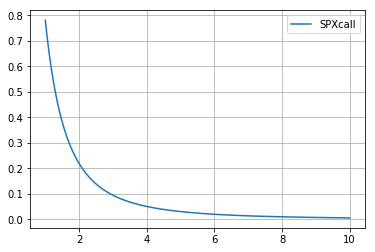

In [34]:
u = np.linspace(1, 10, 10000)
u = np.array([u])
r = 0.0
q = 0.0
#Assuming St == S0, so yt = 0
yt = 0
def SPXcall(u, S0, K, I, tau):
    x0 = np.log(S0)
    k = x0 - np.log(K) + (r - q) * tau
    first = np.exp(1j*u*k - 1j*(u - 1j/2)*x0 - yt + (r - q)*tau)
    second = CFlogPrice(u - 1j/2, tau)
    third = np.exp((-u**2 - 0.25) * I)/(u**2 + 0.25)
    
    SPXcall = (first*second).real * third
    
    return SPXcall

SPXcall = SPXcall(u, 40, 42, 0, 0.5)
plt.plot(u.flatten(), SPXcall.flatten())
plt.legend(['SPXcall'])
#plt.yticks(np.arrange())
plt.grid()

In [46]:
u = np.linspace(1, 100, 1000)
u = np.array([u])
CF = CFlogPrice(u-1j/2, .5)
%matplotlib tk

plt.plot(u.flatten(), CF.flatten())
plt.legend(['SPXcall'])
plt.yticks(np.arange(-6.2, 6.2, step=0.25))
plt.grid()

/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [45]:
pd.DataFrame(CF.flatten()).to_csv(path_or_buf="/home/lin/summerProjectReading/CFlogPrice.csv")

In [23]:
VIXfu4.shape

(1000,)

In [24]:
import scipy.integrate.quadrature as integral

In [25]:
def toInte(z):
    z = np.array([z])
    return VIXfuPricing(z, 45.0/365, 0.0).flatten()